In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pickle

from efficient_fpt.models import DDModel, weibull_survival
from efficient_fpt.utils import adaptive_interpolation
from efficient_fpt.multi_stage import get_multistage_densities

### Example 2: multi-stage approximation to DDMs

#### 2.1 Simulate and visualize the model

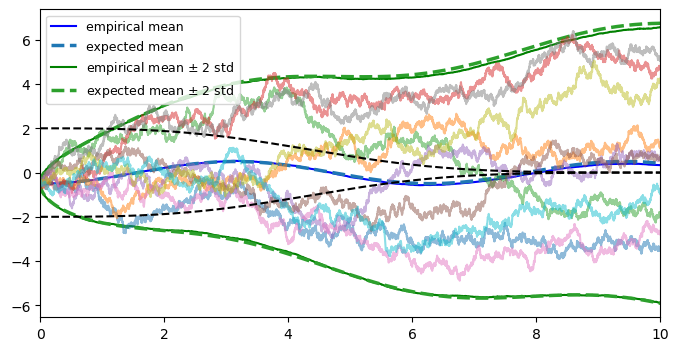

In [2]:
class NonlinearDDModel(DDModel):
    """
    dX(t) = mu(t) dt + sigma dW(t)
    """

    def __init__(self, A, omega, sigma, a, lbda, k, x0):
        super().__init__(x0)
        # drift parameters
        self.A = A
        self.omega = omega
        # diffusion parameter
        self.sigma = sigma
        # Weibull boundary parameters
        self.a = a
        self.lbda = lbda
        self.k = k

    def drift_coeff(self, X: float, t: float) -> float:
        return self.A * np.sin(self.omega * t)
    
    def diffusion_coeff(self, X: float, t: float) -> float:
        return self.sigma

    @property
    def is_update_vectorizable(self):
        return True

    def upper_bdy(self, t):
        return weibull_survival(t, self.lbda, self.k) * self.a

    def lower_bdy(self, t):
        return -weibull_survival(t, self.lbda, self.k) * self.a
    
A = 0.5
omega = 1
sigma = 1
x0 = -0.5
num = 2000


a = 2
lbda = 5
k = 3
T = 10
ddm = NonlinearDDModel(A=A, omega=omega, sigma=sigma, a=a, lbda=lbda, k=k, x0=x0)
t_grid, X_grids = ddm.simulate_trajs(T=T, Nt=1000 * T, num=num)



expected_mean = x0 + A / omega * (1 - np.cos(omega * t_grid))
empirical_mean = np.mean(X_grids, axis=0)
expected_std = sigma * np.sqrt(t_grid)
empirical_std = np.std(X_grids, axis=0)


fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(t_grid, empirical_mean, label="empirical mean", c="b")
ax.plot(t_grid, expected_mean, label="expected mean", linewidth=2.5, linestyle="--", c="tab:blue")
ax.plot(t_grid, empirical_mean + 2 * empirical_std, label=r"empirical mean $\pm$ 2 std", c="g")
ax.plot(t_grid, empirical_mean - 2 * empirical_std, c="g")
ax.plot(t_grid, expected_mean + 2 * expected_std, label=r"expected mean $\pm$ 2 std", linewidth=2.5, linestyle="--", c="tab:green")
ax.plot(t_grid, expected_mean - 2 * expected_std, linewidth=2.5, linestyle="--", c="tab:green")
ax.plot(t_grid, X_grids[:10, :].T, alpha=0.5)
ax.plot(t_grid, ddm.upper_bdy(t_grid), c='k', linestyle="--")
ax.plot(t_grid, ddm.lower_bdy(t_grid), c='k', linestyle="--")
ax.autoscale(axis="x", tight=True)
ax.legend(fontsize=9)
plt.show()

#### 2.2 Simulate first passage times, compute FPTDs and NPDs

##### 2.2.1 For a small $T$, plot both FPTDs and NPD

In [3]:
T = 4
num_fpt = 100000

fp_times, np_poss = ddm.simulate_fptd_tillT(T=T, dt=0.001, num=num_fpt)
counts_t, bins_t = np.histogram(fp_times, bins=100)
dt_bin = bins_t[1] - bins_t[0]
counts_x, bins_x = np.histogram(np_poss, bins=50)
dx_bin = bins_x[1] - bins_x[0]

In [4]:
u_tilde = lambda t: (ddm.upper_bdy(t) - A / omega * (1 - np.cos(omega * t))) / sigma
l_tilde = lambda t: (ddm.lower_bdy(t) - A / omega * (1 - np.cos(omega * t))) / sigma


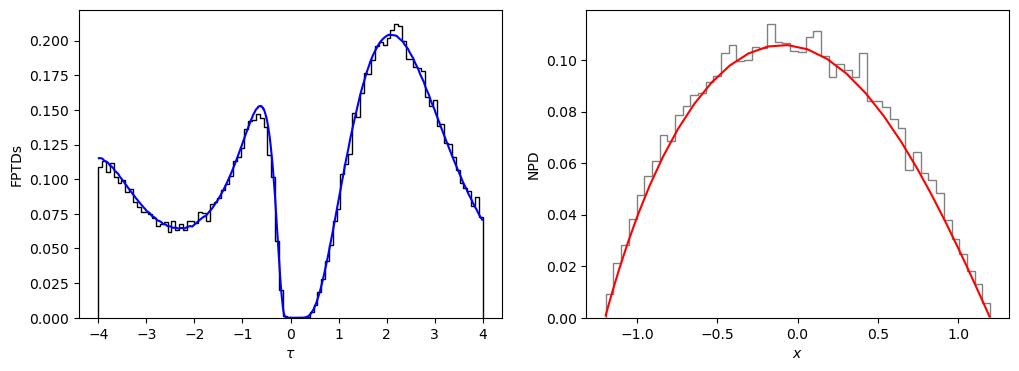

In [5]:

t_intp_array, _ = adaptive_interpolation(u_tilde, [0, T], 0.0005)
b1_array = (u_tilde(t_intp_array)[1:] - u_tilde(t_intp_array)[:-1]) / (t_intp_array[1:] - t_intp_array[:-1])
b2_array = (l_tilde(t_intp_array)[1:] - l_tilde(t_intp_array)[:-1]) / (t_intp_array[1:] - t_intp_array[:-1])
a1 = u_tilde(0)
a2 = l_tilde(0)
mu_array = np.zeros_like(b1_array)
sigma_array = np.ones_like(b1_array)
sacc_array = t_intp_array[:-1]
x0_tilde = x0 / sigma

eps = 1e-2
ts = np.arange(eps, T, 1e-3)
fptds, npds = get_multistage_densities(ts, mu_array, sacc_array, sigma_array, a1, b1_array, a2, b2_array, T, x0=np.array([[1], [x0_tilde]]), eps=eps)

ts, upper_fptds, lower_fptds = fptds[0, :], fptds[1, :], fptds[2, :]
xs, npd = npds[0, :], npds[1, :]
xs = xs * sigma + A / omega * (1 - np.cos(omega * T))

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].stairs(counts_t / num_fpt / dt_bin, bins_t, color="black")
ax[0].plot(ts, upper_fptds, c='b')
ax[0].plot(-ts, lower_fptds, c='b')
ax[0].set_xlabel(r"$\tau$")
ax[0].set_ylabel("FPTDs")

ax[1].stairs(counts_x / num_fpt / dx_bin, bins_x, color="gray")
ax[1].plot(xs, npd, c='r')
ax[1].set_xlabel(r"$x$")
ax[1].set_ylabel("NPD")

plt.show()

##### 2.2.2 For a large $T$, plot the whole FPTDs

In [6]:
T = 10

# num_fpt = 100000
# dt = 1e-5
# fp_times, np_poss = ddm.simulate_fptd_tillT(T=T, dt=dt, num=num_fpt)
# data_to_save = {"fp_times": fp_times, "np_poss": np_poss,
#                 "A": A, "omega": omega, "sigma": sigma, "a": a, "lbda": lbda, "k": k, "T": T, "num_fpt": num_fpt, "dt": dt}
# fname = "ex2_fpt_data_" + time.strftime("%Y%m%d-%H%M%S") + ".pkl"
# with open(fname, "wb") as f:
#     pickle.dump(data_to_save, f)

fpt_data = pickle.load(open("ex2_fpt_data_20250305-184050.pkl", "rb"))
fp_times = fpt_data["fp_times"]
num_fpt = fpt_data["num_fpt"]

counts_t, bins_t = np.histogram(fp_times, bins=100)
dt_bin = bins_t[1] - bins_t[0]

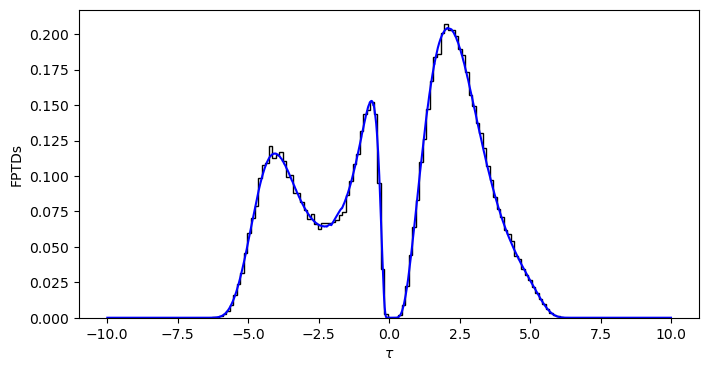

In [7]:
t_intp_array, _ = adaptive_interpolation(u_tilde, [0, T], 0.0005)
b1_array = (u_tilde(t_intp_array)[1:] - u_tilde(t_intp_array)[:-1]) / (t_intp_array[1:] - t_intp_array[:-1])
b2_array = (l_tilde(t_intp_array)[1:] - l_tilde(t_intp_array)[:-1]) / (t_intp_array[1:] - t_intp_array[:-1])
a1 = u_tilde(0)
a2 = l_tilde(0)
mu_array = np.zeros_like(b1_array)
sigma_array = np.ones_like(b1_array)
sacc_array = t_intp_array[:-1]
x0_tilde = x0 / sigma

eps = 1e-2
ts = np.arange(eps, T, 1e-3)
fptds, npds = get_multistage_densities(ts, mu_array, sacc_array, sigma_array, a1, b1_array, a2, b2_array, T, x0=np.array([[1], [x0_tilde]]), eps=eps)

ts, upper_fptds, lower_fptds = fptds[0, :], fptds[1, :], fptds[2, :]

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.stairs(counts_t / num_fpt / dt_bin, bins_t, color="black")

ax.plot(ts, upper_fptds, c='b')
ax.plot(-ts, lower_fptds, c='b')
ax.set_xlabel(r"$\tau$")
ax.set_ylabel("FPTDs")

plt.show()

make plot for the paper

In [8]:
import matplotlib as mpl

import os
if '/oscar/home/sliu167/texlive/2024/bin/x86_64-linux' not in os.environ['PATH']:
    os.environ['PATH'] = '/oscar/home/sliu167/texlive/2024/bin/x86_64-linux:' + os.environ['PATH']

mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}\usepackage{amsfonts}'

from scipy.integrate import cumulative_trapezoid
from scipy.stats import ks_1samp, ecdf

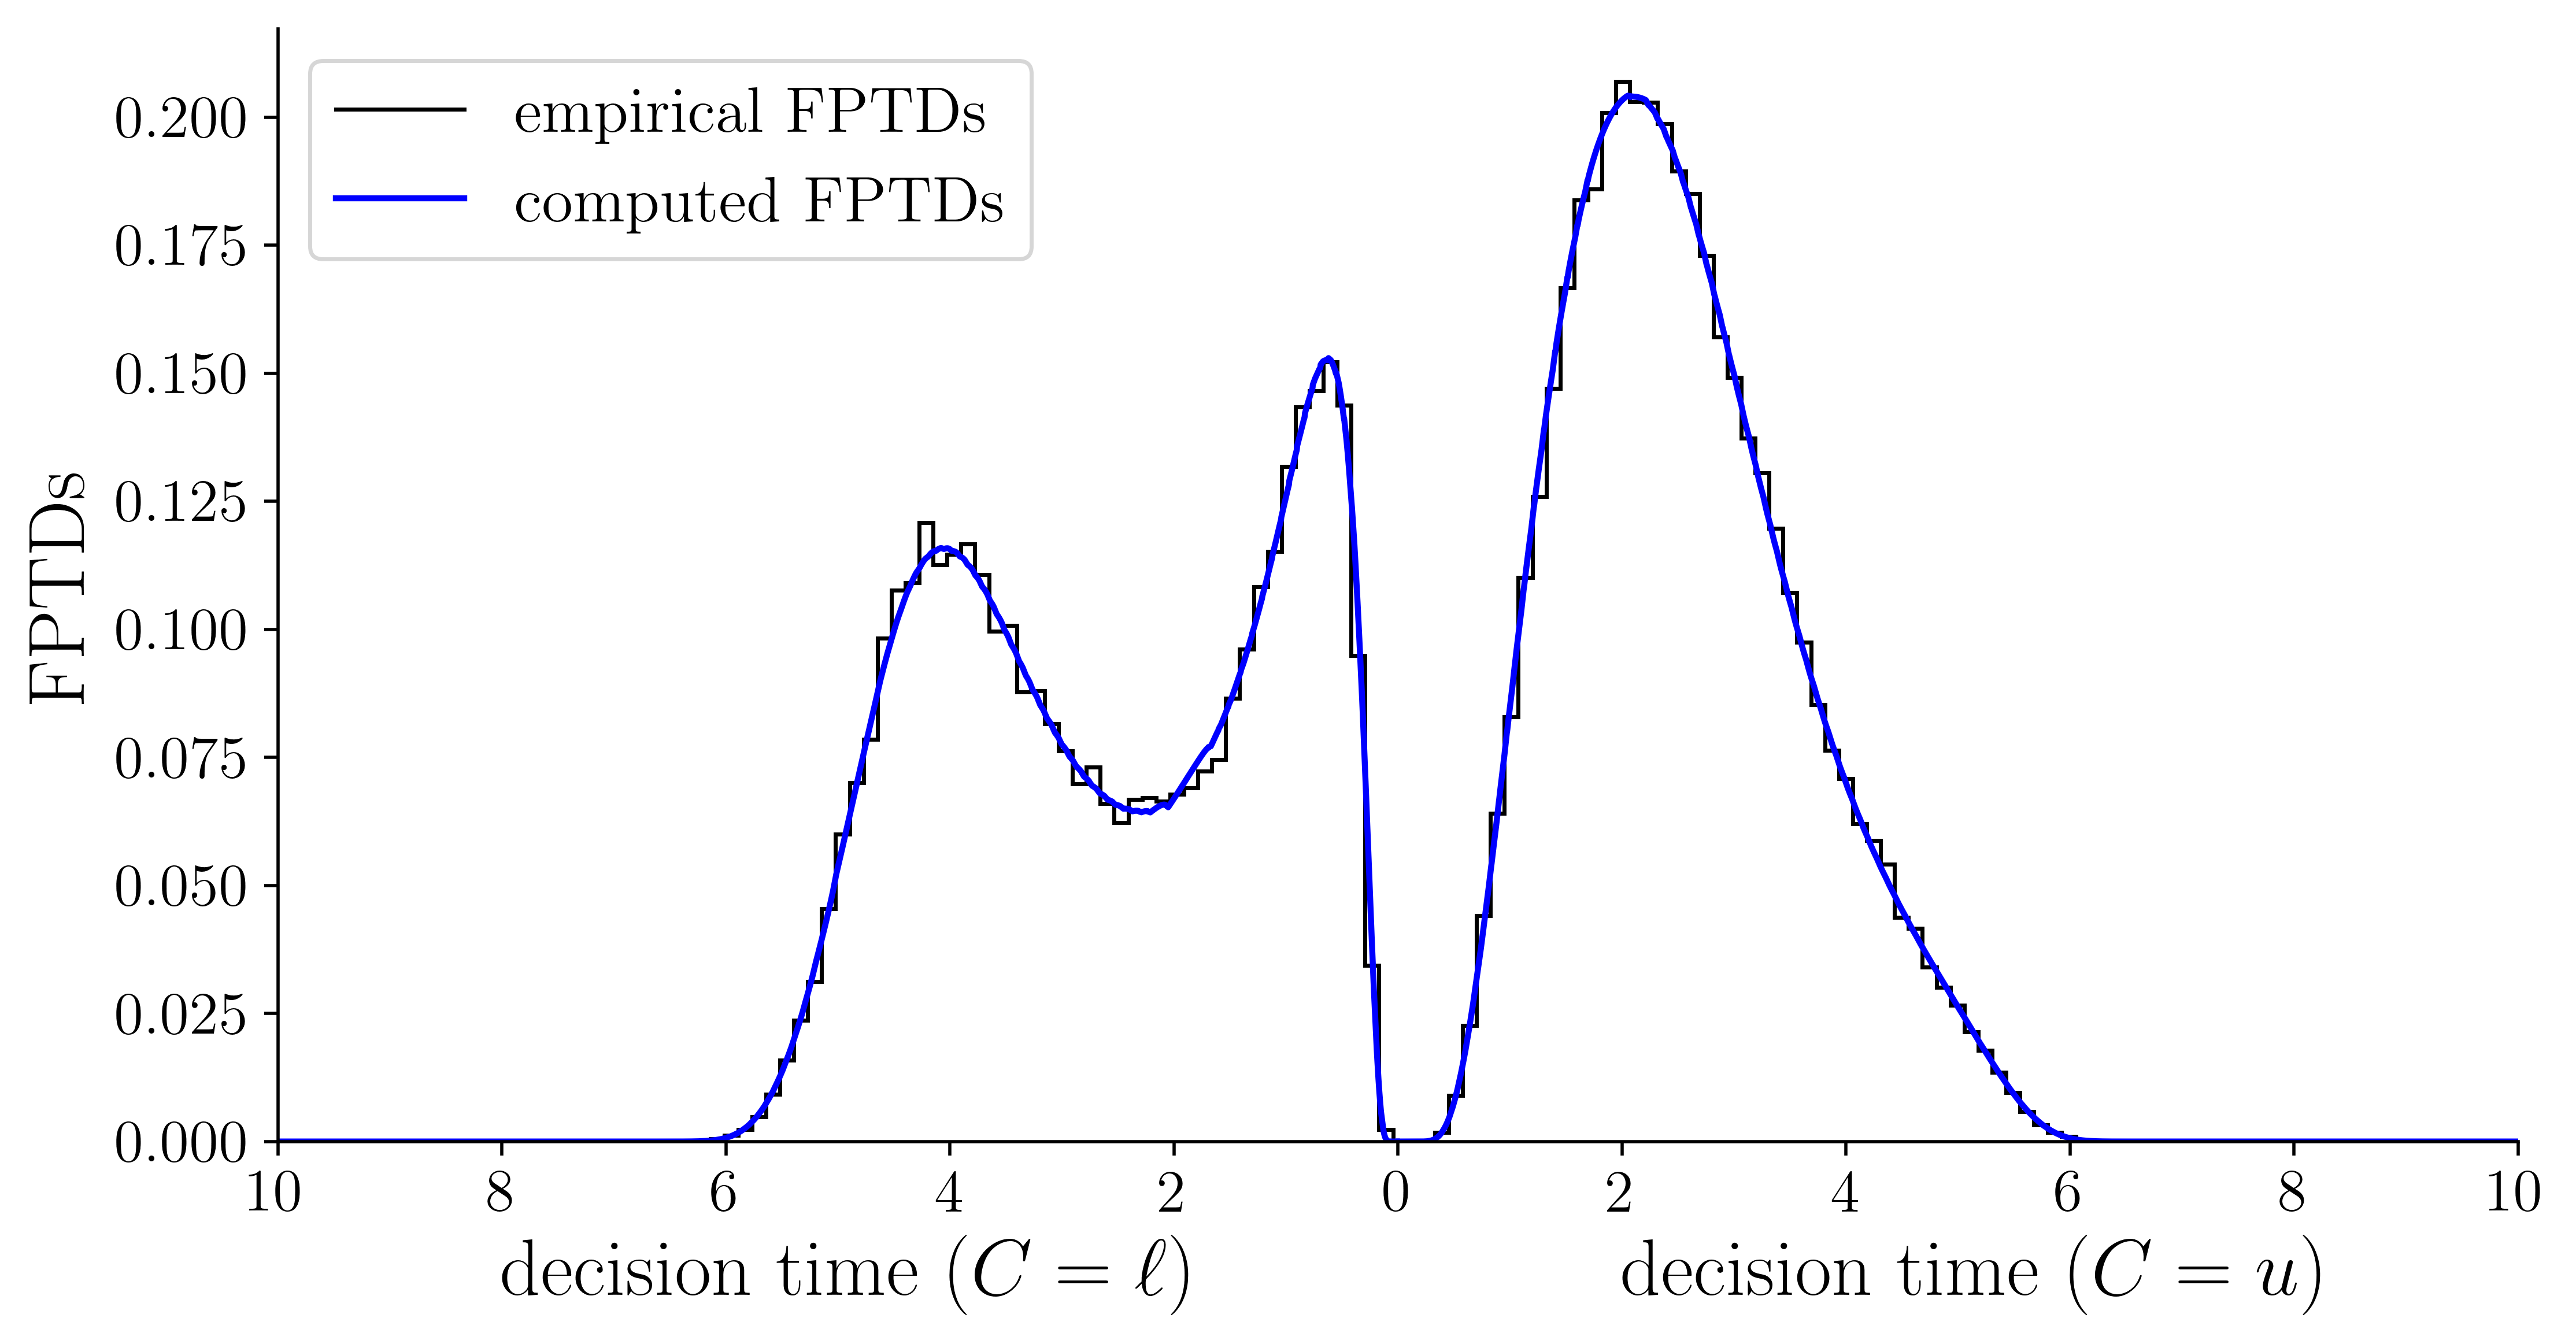

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=500)
ax.stairs(counts_t / num_fpt / dt_bin, bins_t, color="black", label="empirical FPTDs")
ax.plot(ts, upper_fptds, c='b', label="computed FPTDs")
ax.plot(-ts, lower_fptds, c='b')
ax.legend(fontsize=16, loc="upper left")

ax.text(-8, -0.03, r"decision time ($C=\ell$)", fontsize=20)
ax.text(2, -0.03, r"decision time ($C=u$)", fontsize=20)
ax.set_ylabel("FPTDs", fontsize=20)

ax.autoscale(tight=True, axis="x")

ax.set_xticks(np.arange(-10, 11, 2))
ax.set_xticklabels(np.hstack([np.arange(10, 0, -2), np.arange(0, 11, 2)]), fontsize=15)
# yticks = np.arange(0, 0.65, 0.1)
# ax.set_yticks(yticks)
# ax.set_yticklabels([f"{y:.1f}" for y in yticks], fontsize=15)
# ax.set_yticks([])
ax.spines[['right', 'top']].set_visible(False)


ax.tick_params(axis='both', labelsize=15)
ax.spines[['right', 'top']].set_visible(False)

plt.savefig('ex2-figure.png', format='png', bbox_inches='tight', transparent=True)
plt.show()

In [10]:
ts_all = np.hstack((-ts[::-1], [0], ts))
fptd_all = np.hstack((lower_fptds[::-1], [0], upper_fptds))

cdf = cumulative_trapezoid(fptd_all, ts_all, initial=0)
cdf_func = lambda x: np.interp(x, ts_all, cdf)
ecdf_result = ecdf(fp_times)
# plt.plot(ts_all, cdf, c='b', label='CDF')
# plt.plot(ts_all, ecdf_result.cdf.evaluate(ts_all), c='r', label='CDF interp')
# plt.show()

for num_data in [10000, 20000, 50000, 100000]:
    pvalue = ks_1samp(fp_times[: num_data], cdf_func, method="exact").pvalue
    print(f"#data = {num_data}, p-value = {pvalue}")

#data = 10000, p-value = 0.7783909412539397
#data = 20000, p-value = 0.7026702317782315
#data = 50000, p-value = 0.49829241714170525
#data = 100000, p-value = 0.4990881496236833
